In [1]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 120


In [2]:
def load_jsonl(path: str, model_label: str) -> pd.DataFrame:
    file_path = Path(path)
    if not file_path.exists():
        print(f"Aviso: arquivo {path} não encontrado.")
        return pd.DataFrame()

    rows = []
    with file_path.open(encoding="utf-8") as fp:
        for line in fp:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))

    if not rows:
        print(f"Aviso: arquivo {path} está vazio.")
        return pd.DataFrame()

    df = pd.DataFrame(rows)

    # Normaliza nomes de coluna
    df['puzzle_file'] = df['puzzle'] if 'puzzle' in df.columns else df.get('puzzle_file')
    df['llm_answer'] = df['llm'] if 'llm' in df.columns else df.get('llm_answer')
    df['z3_answer'] = df['z3_consequencias'] if 'z3_consequencias' in df.columns else df.get('z3_answer')

    df['model_name'] = df['model'] if 'model' in df.columns else model_label
    df['match'] = df['match'].astype(bool) if 'match' in df.columns else False

    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    else:
        fallback = pd.Timestamp.fromtimestamp(file_path.stat().st_mtime)
        df['timestamp'] = fallback

    return df


In [3]:
GEMINI_LABEL = "gemini-2.5-flash"
GPT_LABEL = "gpt-4o-mini"
PUZZLES_DIR = Path("puzzles")
TOTAL_PUZZLES = len(list(PUZZLES_DIR.glob("*.txt"))) if PUZZLES_DIR.exists() else None

# Carrega dados
gemini_df = load_jsonl("resultados/results.jsonl", GEMINI_LABEL)
gpt_df = load_jsonl("resultados/results_gpt.jsonl", GPT_LABEL)

if not isinstance(gemini_df, pd.DataFrame):
    gemini_df = pd.DataFrame()
if not isinstance(gpt_df, pd.DataFrame):
    gpt_df = pd.DataFrame()

dfs = [d for d in (gemini_df, gpt_df) if isinstance(d, pd.DataFrame) and not d.empty]
if not dfs:
    print("Sem dados disponíveis. Execute os scripts principais antes de rodar este notebook.")
    df = pd.DataFrame()
else:
    df = pd.concat(dfs, ignore_index=True)
    df = df.sort_values("timestamp")
    display(df.head())


,puzzle,llm,z3_consequencias,match,puzzle_file,llm_answer,z3_answer,model_name,timestamp
0,puzzle1.txt,"{'A': 'patife', 'B': 'cavaleiro'}","{'A': 'Patife (necessariamente falso)', 'B': 'Cavaleiro (necessariamente verdadeiro)'}",True,puzzle1.txt,"{'A': 'patife', 'B': 'cavaleiro'}","{'A': 'Patife (necessariamente falso)', 'B': 'Cavaleiro (necessariamente verdadeiro)'}",gemini-2.5-flash,2025-12-10 08:54:50.874502
1,puzzle2.txt,"{'A': 'indeterminado', 'B': 'indeterminado', 'C': 'cavaleiro'}","{'A': 'Indeterminado (pode ser ambos)', 'B': 'Indeterminado (pode ser ambos)', 'C': 'Cavaleiro (necessariamente verd...",True,puzzle2.txt,"{'A': 'indeterminado', 'B': 'indeterminado', 'C': 'cavaleiro'}","{'A': 'Indeterminado (pode ser ambos)', 'B': 'Indeterminado (pode ser ambos)', 'C': 'Cavaleiro (necessariamente verd...",gemini-2.5-flash,2025-12-10 08:54:50.874502
2,puzzle3.txt,"{'A': 'cavaleiro', 'B': 'patife', 'C': 'patife'}","{'A': 'Cavaleiro (necessariamente verdadeiro)', 'B': 'Patife (necessariamente falso)', 'C': 'Patife (necessariamente...",True,puzzle3.txt,"{'A': 'cavaleiro', 'B': 'patife', 'C': 'patife'}","{'A': 'Cavaleiro (necessariamente verdadeiro)', 'B': 'Patife (necessariamente falso)', 'C': 'Patife (necessariamente...",gemini-2.5-flash,2025-12-10 08:54:50.874502
3,puzzle4.txt,{},"{'A': 'Inconsistente (sem modelo possível)', 'B': 'Inconsistente (sem modelo possível)', 'C': 'Inconsistente (sem mo...",False,puzzle4.txt,{},"{'A': 'Inconsistente (sem modelo possível)', 'B': 'Inconsistente (sem modelo possível)', 'C': 'Inconsistente (sem mo...",gemini-2.5-flash,2025-12-10 08:54:50.874502
4,puzzle5.txt,"{'A': 'patife', 'B': 'indeterminado', 'C': 'cavaleiro'}","{'A': 'Patife (necessariamente falso)', 'B': 'Indeterminado (pode ser ambos)', 'C': 'Cavaleiro (necessariamente verd...",True,puzzle5.txt,"{'A': 'patife', 'B': 'indeterminado', 'C': 'cavaleiro'}","{'A': 'Patife (necessariamente falso)', 'B': 'Indeterminado (pode ser ambos)', 'C': 'Cavaleiro (necessariamente verd...",gemini-2.5-flash,2025-12-10 08:54:50.874502


In [4]:
# Resumo geral
if df.empty:
    print("Sem dados disponíveis. Execute os scripts principais antes de rodar este notebook.")
else:
    latest = (
        df.sort_values("timestamp")
          .drop_duplicates(["puzzle_file", "model_name"], keep="last")
    )

    gemini_acertos = latest[(latest["model_name"] == GEMINI_LABEL) & (latest["match"])].puzzle_file.nunique()
    gpt_acertos = latest[(latest["model_name"] == GPT_LABEL) & (latest["match"])].puzzle_file.nunique()

    resumo_total = pd.DataFrame([{
        "total_puzzles": TOTAL_PUZZLES,
        "gemini_acertos": gemini_acertos,
        "gpt_acertos": gpt_acertos,
        "gemini_erros": latest[(latest["model_name"] == GEMINI_LABEL) & (~latest["match"])].puzzle_file.nunique(),
        "gpt_erros": latest[(latest["model_name"] == GPT_LABEL) & (~latest["match"])].puzzle_file.nunique(),
    }])

    display(resumo_total)


,total_puzzles,gemini_acertos,gpt_acertos,gemini_erros,gpt_erros
0,15,4,1,1,4


In [5]:
# Erros do Gemini
if df.empty:
    print("Sem dados disponíveis. Execute os scripts principais antes de rodar este notebook.")
else:
    latest = (
        df.sort_values("timestamp")
          .drop_duplicates(["puzzle_file", "model_name"], keep="last")
    )

    gemini_erros = latest[(latest["model_name"] == GEMINI_LABEL) & (~latest["match"])]

    if gemini_erros.empty:
        print("Gemini não errou nenhum puzzle.")
    else:
        display(gemini_erros[["puzzle_file", "llm_answer", "z3_answer", "timestamp"]])


,puzzle_file,llm_answer,z3_answer,timestamp
3,puzzle4.txt,{},"{'A': 'Inconsistente (sem modelo possível)', 'B': 'Inconsistente (sem modelo possível)', 'C': 'Inconsistente (sem mo...",2025-12-10 08:54:50.874502


In [6]:
# Erros do GPT
if df.empty:
    print("Sem dados disponíveis. Execute os scripts principais antes de rodar este notebook.")
else:
    latest = (
        df.sort_values("timestamp")
          .drop_duplicates(["puzzle_file", "model_name"], keep="last")
    )

    gpt_erros = latest[(latest["model_name"] == GPT_LABEL) & (~latest["match"])]

    if gpt_erros.empty:
        print("GPT não errou nenhum puzzle.")
    else:
        display(gpt_erros[["puzzle_file", "llm_answer", "z3_answer", "timestamp"]])


,puzzle_file,llm_answer,z3_answer,timestamp
5,puzzle1.txt,"{'A': 'cavaleiro', 'B': 'patife'}","{'A': 'Patife (necessariamente falso)', 'B': 'Cavaleiro (necessariamente verdadeiro)'}",2025-12-10 09:28:03.325780
6,puzzle2.txt,"{'A': 'cavaleiro', 'B': 'patife', 'C': 'cavaleiro'}","{'A': 'Indeterminado (pode ser ambos)', 'B': 'Indeterminado (pode ser ambos)', 'C': 'Cavaleiro (necessariamente verd...",2025-12-10 09:28:03.325780
8,puzzle4.txt,"{'A': 'cavaleiro', 'B': 'patife', 'C': 'cavaleiro'}","{'A': 'Inconsistente (sem modelo possível)', 'B': 'Inconsistente (sem modelo possível)', 'C': 'Inconsistente (sem mo...",2025-12-10 09:28:03.325780
9,puzzle5.txt,"{'A': 'patife', 'B': 'patife', 'C': 'cavaleiro'}","{'A': 'Patife (necessariamente falso)', 'B': 'Indeterminado (pode ser ambos)', 'C': 'Cavaleiro (necessariamente verd...",2025-12-10 09:28:03.325780


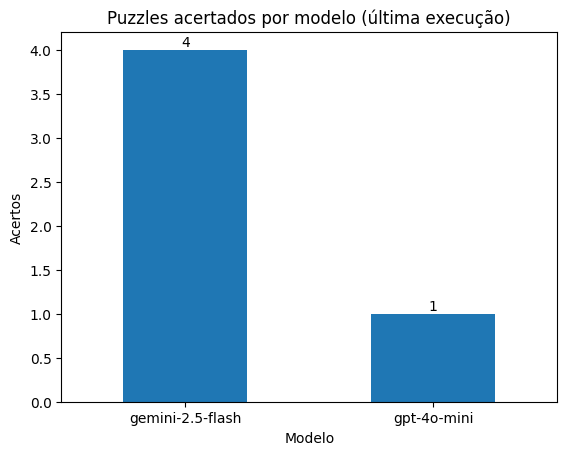

In [7]:
# Gráfico de acertos por modelo
if df.empty:
    print('Sem dados disponíveis. Execute os scripts principais antes de rodar este notebook.')
else:
    latest = (
        df.sort_values('timestamp')
          .drop_duplicates(['puzzle_file', 'model_name'], keep='last')
    )

    acertos = (
        latest[latest['match']]
          .groupby('model_name')['puzzle_file']
          .nunique()
          .reset_index(name='acertos')
    )

    if acertos.empty:
        print('Sem acertos registrados.')
    else:
        ax = acertos.set_index('model_name').plot(kind='bar', legend=False, rot=0)
        ax.set_ylabel('Acertos')
        ax.set_xlabel('Modelo')
        ax.set_title('Puzzles acertados por modelo (última execução)')
        for p in ax.patches:
            label = f"{int(p.get_height())}"
            ax.annotate(label, (p.get_x() + p.get_width()/2, p.get_height()),
                        ha='center', va='bottom')
        plt.show()
